In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)

In [2]:
# get the lap times, races, and circuits
laptimes_df = pd.read_csv('lap_times.csv').replace('\\N', np.nan)
races_df = pd.read_csv('races.csv').replace('\\N', np.nan)
circuits_df = pd.read_csv('circuits.csv').replace('\\N', np.nan)
pit_stops_df = pd.read_csv('pit_stops.csv').replace('\\N', np.nan)

pd.get_option("display.max_columns",None)

In [3]:
laptimes_df.head() 

,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342


In [4]:
races_df.drop(['fp1_date','fp1_time','fp2_date','fp2_time','fp3_date','fp3_time','quali_date','quali_time','sprint_date','sprint_time', 'url', 'date', 'time', 'round'], axis=1, inplace=True)
races_df.circuitId = races_df.circuitId.astype(int)
races_df.head() 

,raceId,year,circuitId,name
0,1,2009,1,Australian Grand Prix
1,2,2009,2,Malaysian Grand Prix
2,3,2009,17,Chinese Grand Prix
3,4,2009,3,Bahrain Grand Prix
4,5,2009,4,Spanish Grand Prix


In [5]:
circuits_df.drop(['circuitRef','location','country','url'], axis=1, inplace=True)
circuits_df.circuitId = circuits_df.circuitId.astype(int)

circuits_df.head()

,circuitId,name,lat,lng,alt
0,1,Albert Park Grand Prix Circuit,-37.84970,144.96800,10
1,2,Sepang International Circuit,2.76083,101.73800,18
2,3,Bahrain International Circuit,26.03250,50.51060,7
3,4,Circuit de Barcelona-Catalunya,41.57000,2.26111,109
4,5,Istanbul Park,40.95170,29.40500,130


In [6]:
# this cell gets the average and max for raceId/driverId pairs
pit_stops_averaged_df = pit_stops_df.groupby(["raceId", "driverId"])["milliseconds"].agg(["mean", "max", "min"]).reset_index()

pit_stops_averaged_df.head()

,raceId,driverId,mean,max,min
0,841,1,23213.0,23227,23199
1,841,2,24046.0,25098,22994
2,841,3,23716.0,23716,23716
3,841,4,24055.0,24733,23251
4,841,5,24865.0,24865,24865


In [7]:
# add total number of stops
df1 = pit_stops_df.groupby(["raceId", "driverId"])["stop"].max().reset_index()

pit_stops_averaged_df = pd.merge(pit_stops_averaged_df, df1, on=["raceId", "driverId"])

# rename the columns
pit_stops_averaged_df.rename(columns={'mean':'avg_pitstop','max':'longest_pitstop','min':'shortest_pitstop','stop':'pitstops'}, inplace=True)
pit_stops_averaged_df.head()

,raceId,driverId,avg_pitstop,longest_pitstop,shortest_pitstop,pitstops
0,841,1,23213.0,23227,23199,2
1,841,2,24046.0,25098,22994,2
2,841,3,23716.0,23716,23716,1
3,841,4,24055.0,24733,23251,3
4,841,5,24865.0,24865,24865,1


In [8]:
# merge the circuit/race/pitstop data into the laptimes dataframe
con1 = pd.merge(races_df, circuits_df, on = 'circuitId')
con1.head()
con2 = pd.merge(con1, laptimes_df, on = 'raceId')
df = pd.merge(con2, pit_stops_averaged_df, on=['raceId','driverId'])


In [9]:
df.tail()

,raceId,year,circuitId,name_x,name_y,lat,lng,alt,driverId,lap,position,time,milliseconds,avg_pitstop,longest_pitstop,shortest_pitstop,pitstops
267109,1078,2022,79,Miami Grand Prix,Miami International Autodrome,25.9581,-80.2389,NaN,20,50,11,1:33.479,93479,19861.0,19861,19861,1
267110,1078,2022,79,Miami Grand Prix,Miami International Autodrome,25.9581,-80.2389,NaN,20,51,11,1:34.298,94298,19861.0,19861,19861,1
267111,1078,2022,79,Miami Grand Prix,Miami International Autodrome,25.9581,-80.2389,NaN,20,52,11,1:34.217,94217,19861.0,19861,19861,1
267112,1078,2022,79,Miami Grand Prix,Miami International Autodrome,25.9581,-80.2389,NaN,20,53,9,1:33.631,93631,19861.0,19861,19861,1
267113,1078,2022,79,Miami Grand Prix,Miami International Autodrome,25.9581,-80.2389,NaN,20,54,17,1:59.970,119970,19861.0,19861,19861,1


In [10]:
# check which columns have NaN values
df.isna().any()

raceId              False
year                False
circuitId           False
name_x              False
name_y              False
lat                 False
lng                 False
alt                  True
driverId            False
lap                 False
position            False
time                False
milliseconds        False
avg_pitstop         False
longest_pitstop     False
shortest_pitstop    False
pitstops            False
dtype: bool

In [11]:
# df data types
df.dtypes

raceId                int64
year                  int64
circuitId             int32
name_x               object
name_y               object
lat                 float64
lng                 float64
alt                  object
driverId              int64
lap                   int64
position              int64
time                 object
milliseconds          int64
avg_pitstop         float64
longest_pitstop       int64
shortest_pitstop      int64
pitstops              int64
dtype: object

In [12]:
def time_str_to_seconds(time_str):
    if (len(time_str.split(":")) == 2):
        minutes, seconds = map(float, time_str.split(":"))
        return minutes * 60 + seconds
    else:
        return np.nan

In [13]:
# convert time into seconds for each lap.
df['time'] = df['time'].map(lambda x: time_str_to_seconds(x))

df.tail()

,raceId,year,circuitId,name_x,name_y,lat,lng,alt,driverId,lap,position,time,milliseconds,avg_pitstop,longest_pitstop,shortest_pitstop,pitstops
267109,1078,2022,79,Miami Grand Prix,Miami International Autodrome,25.9581,-80.2389,NaN,20,50,11,93.479,93479,19861.0,19861,19861,1
267110,1078,2022,79,Miami Grand Prix,Miami International Autodrome,25.9581,-80.2389,NaN,20,51,11,94.298,94298,19861.0,19861,19861,1
267111,1078,2022,79,Miami Grand Prix,Miami International Autodrome,25.9581,-80.2389,NaN,20,52,11,94.217,94217,19861.0,19861,19861,1
267112,1078,2022,79,Miami Grand Prix,Miami International Autodrome,25.9581,-80.2389,NaN,20,53,9,93.631,93631,19861.0,19861,19861,1
267113,1078,2022,79,Miami Grand Prix,Miami International Autodrome,25.9581,-80.2389,NaN,20,54,17,119.970,119970,19861.0,19861,19861,1


In [14]:
# check the number of NaN values
df.isnull().sum()

raceId                 0
year                   0
circuitId              0
name_x                 0
name_y                 0
lat                    0
lng                    0
alt                 2161
driverId               0
lap                    0
position               0
time                  41
milliseconds           0
avg_pitstop            0
longest_pitstop        0
shortest_pitstop       0
pitstops               0
dtype: int64

In [15]:
# fill NaN with averages
df['alt'] = pd.to_numeric(df['alt'])
df['time'] = pd.to_numeric(df['time'])

NaN_columns = ['alt', 'time']
for column in NaN_columns:
    df[column].fillna(int(df[column].mean()), inplace=True)

In [16]:
# drop the race name
df.drop(['name_x'], axis=1, inplace=True)

In [17]:
df.tail(20)

,raceId,year,circuitId,name_y,lat,lng,alt,driverId,lap,position,time,milliseconds,avg_pitstop,longest_pitstop,shortest_pitstop,pitstops
267094,1078,2022,79,Miami International Autodrome,25.9581,-80.2389,239.0,20,35,15,97.375,97375,19861.0,19861,19861,1
267095,1078,2022,79,Miami International Autodrome,25.9581,-80.2389,239.0,20,36,15,93.971,93971,19861.0,19861,19861,1
267096,1078,2022,79,Miami International Autodrome,25.9581,-80.2389,239.0,20,37,15,94.137,94137,19861.0,19861,19861,1
267097,1078,2022,79,Miami International Autodrome,25.9581,-80.2389,239.0,20,38,15,93.944,93944,19861.0,19861,19861,1
267098,1078,2022,79,Miami International Autodrome,25.9581,-80.2389,239.0,20,39,15,93.596,93596,19861.0,19861,19861,1
267099,1078,2022,79,Miami International Autodrome,25.9581,-80.2389,239.0,20,40,13,112.102,112102,19861.0,19861,19861,1
267100,1078,2022,79,Miami International Autodrome,25.9581,-80.2389,239.0,20,41,14,125.540,125540,19861.0,19861,19861,1
267101,1078,2022,79,Miami International Autodrome,25.9581,-80.2389,239.0,20,42,14,132.994,132994,19861.0,19861,19861,1
267102,1078,2022,79,Miami International Autodrome,25.9581,-80.2389,239.0,20,43,14,113.143,113143,19861.0,19861,19861,1
267103,1078,2022,79,Miami International Autodrome,25.9581,-80.2389,239.0,20,44,14,150.199,150199,19861.0,19861,19861,1


In [18]:
df.drop(['name_y', 'raceId'], axis=1, inplace=True)

In [19]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,year,circuitId,lat,lng,alt,driverId,lap,position,time,milliseconds,avg_pitstop,longest_pitstop,shortest_pitstop,pitstops
year,1.000000,0.220961,0.092906,-0.161960,0.127721,0.359479,0.019848,-0.088419,-0.032872,-0.033325,0.176260,0.195338,0.033601,-0.213866
circuitId,0.220961,1.000000,0.150529,-0.168948,0.186471,0.077442,-0.022321,-0.020199,-0.000389,-0.006196,0.018133,0.021291,0.024183,-0.149997
lat,0.092906,0.150529,1.000000,-0.244776,-0.152288,0.028128,-0.007062,0.013771,-0.020493,-0.007258,-0.030325,0.007764,-0.080333,-0.114695
lng,-0.161960,-0.168948,-0.244776,1.000000,-0.496246,-0.049687,-0.093324,0.011425,0.087897,0.047622,-0.012334,0.004508,-0.022868,0.097786
alt,0.127721,0.186471,-0.152288,-0.496246,1.000000,0.047413,0.074362,-0.009712,-0.073868,-0.052683,-0.013616,-0.030668,0.020794,-0.065109
driverId,0.359479,0.077442,0.028128,-0.049687,0.047413,1.000000,0.000806,0.221225,-0.009502,-0.012526,0.054755,0.055373,0.017672,-0.088235
lap,0.019848,-0.022321,-0.007062,-0.093324,0.074362,0.000806,1.000000,-0.080422,-0.092640,-0.066975,-0.021557,-0.024881,-0.002813,0.015695
position,-0.088419,-0.020199,0.013771,0.011425,-0.009712,0.221225,-0.080422,1.000000,0.017997,0.014226,-0.042152,-0.031893,-0.033564,0.103646
time,-0.032872,-0.000389,-0.020493,0.087897,-0.073868,-0.009502,-0.092640,0.017997,1.000000,0.661978,0.135349,0.141102,0.052080,0.066501
milliseconds,-0.033325,-0.006196,-0.007258,0.047622,-0.052683,-0.012526,-0.066975,0.014226,0.661978,1.000000,0.087918,0.091528,0.034119,0.049829


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import tree

In [21]:
x = df.drop('year', axis=1)
y = df.year

In [22]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

In [23]:
clf = DecisionTreeClassifier(max_depth=5,random_state=1234)
clf.fit(xtrain, ytrain)

DecisionTreeClassifier(max_depth=5, random_state=1234)

In [24]:
tree.export_text(clf)

'|--- feature_4 <= 838.50\n|   |--- feature_4 <= 824.50\n|   |   |--- feature_12 <= 1.50\n|   |   |   |--- feature_10 <= 23291.50\n|   |   |   |   |--- feature_3 <= 216.50\n|   |   |   |   |   |--- class: 2012\n|   |   |   |   |--- feature_3 >  216.50\n|   |   |   |   |   |--- class: 2019\n|   |   |   |--- feature_10 >  23291.50\n|   |   |   |   |--- feature_0 <= 73.00\n|   |   |   |   |   |--- class: 2018\n|   |   |   |   |--- feature_0 >  73.00\n|   |   |   |   |   |--- class: 2020\n|   |   |--- feature_12 >  1.50\n|   |   |   |--- feature_4 <= 817.50\n|   |   |   |   |--- feature_11 <= 21917.00\n|   |   |   |   |   |--- class: 2011\n|   |   |   |   |--- feature_11 >  21917.00\n|   |   |   |   |   |--- class: 2011\n|   |   |   |--- feature_4 >  817.50\n|   |   |   |   |--- feature_6 <= 10.50\n|   |   |   |   |   |--- class: 2014\n|   |   |   |   |--- feature_6 >  10.50\n|   |   |   |   |   |--- class: 2013\n|   |--- feature_4 >  824.50\n|   |   |--- feature_4 <= 834.50\n|   |   |   |

In [25]:
fn = list(df.columns)
fn.remove('year')

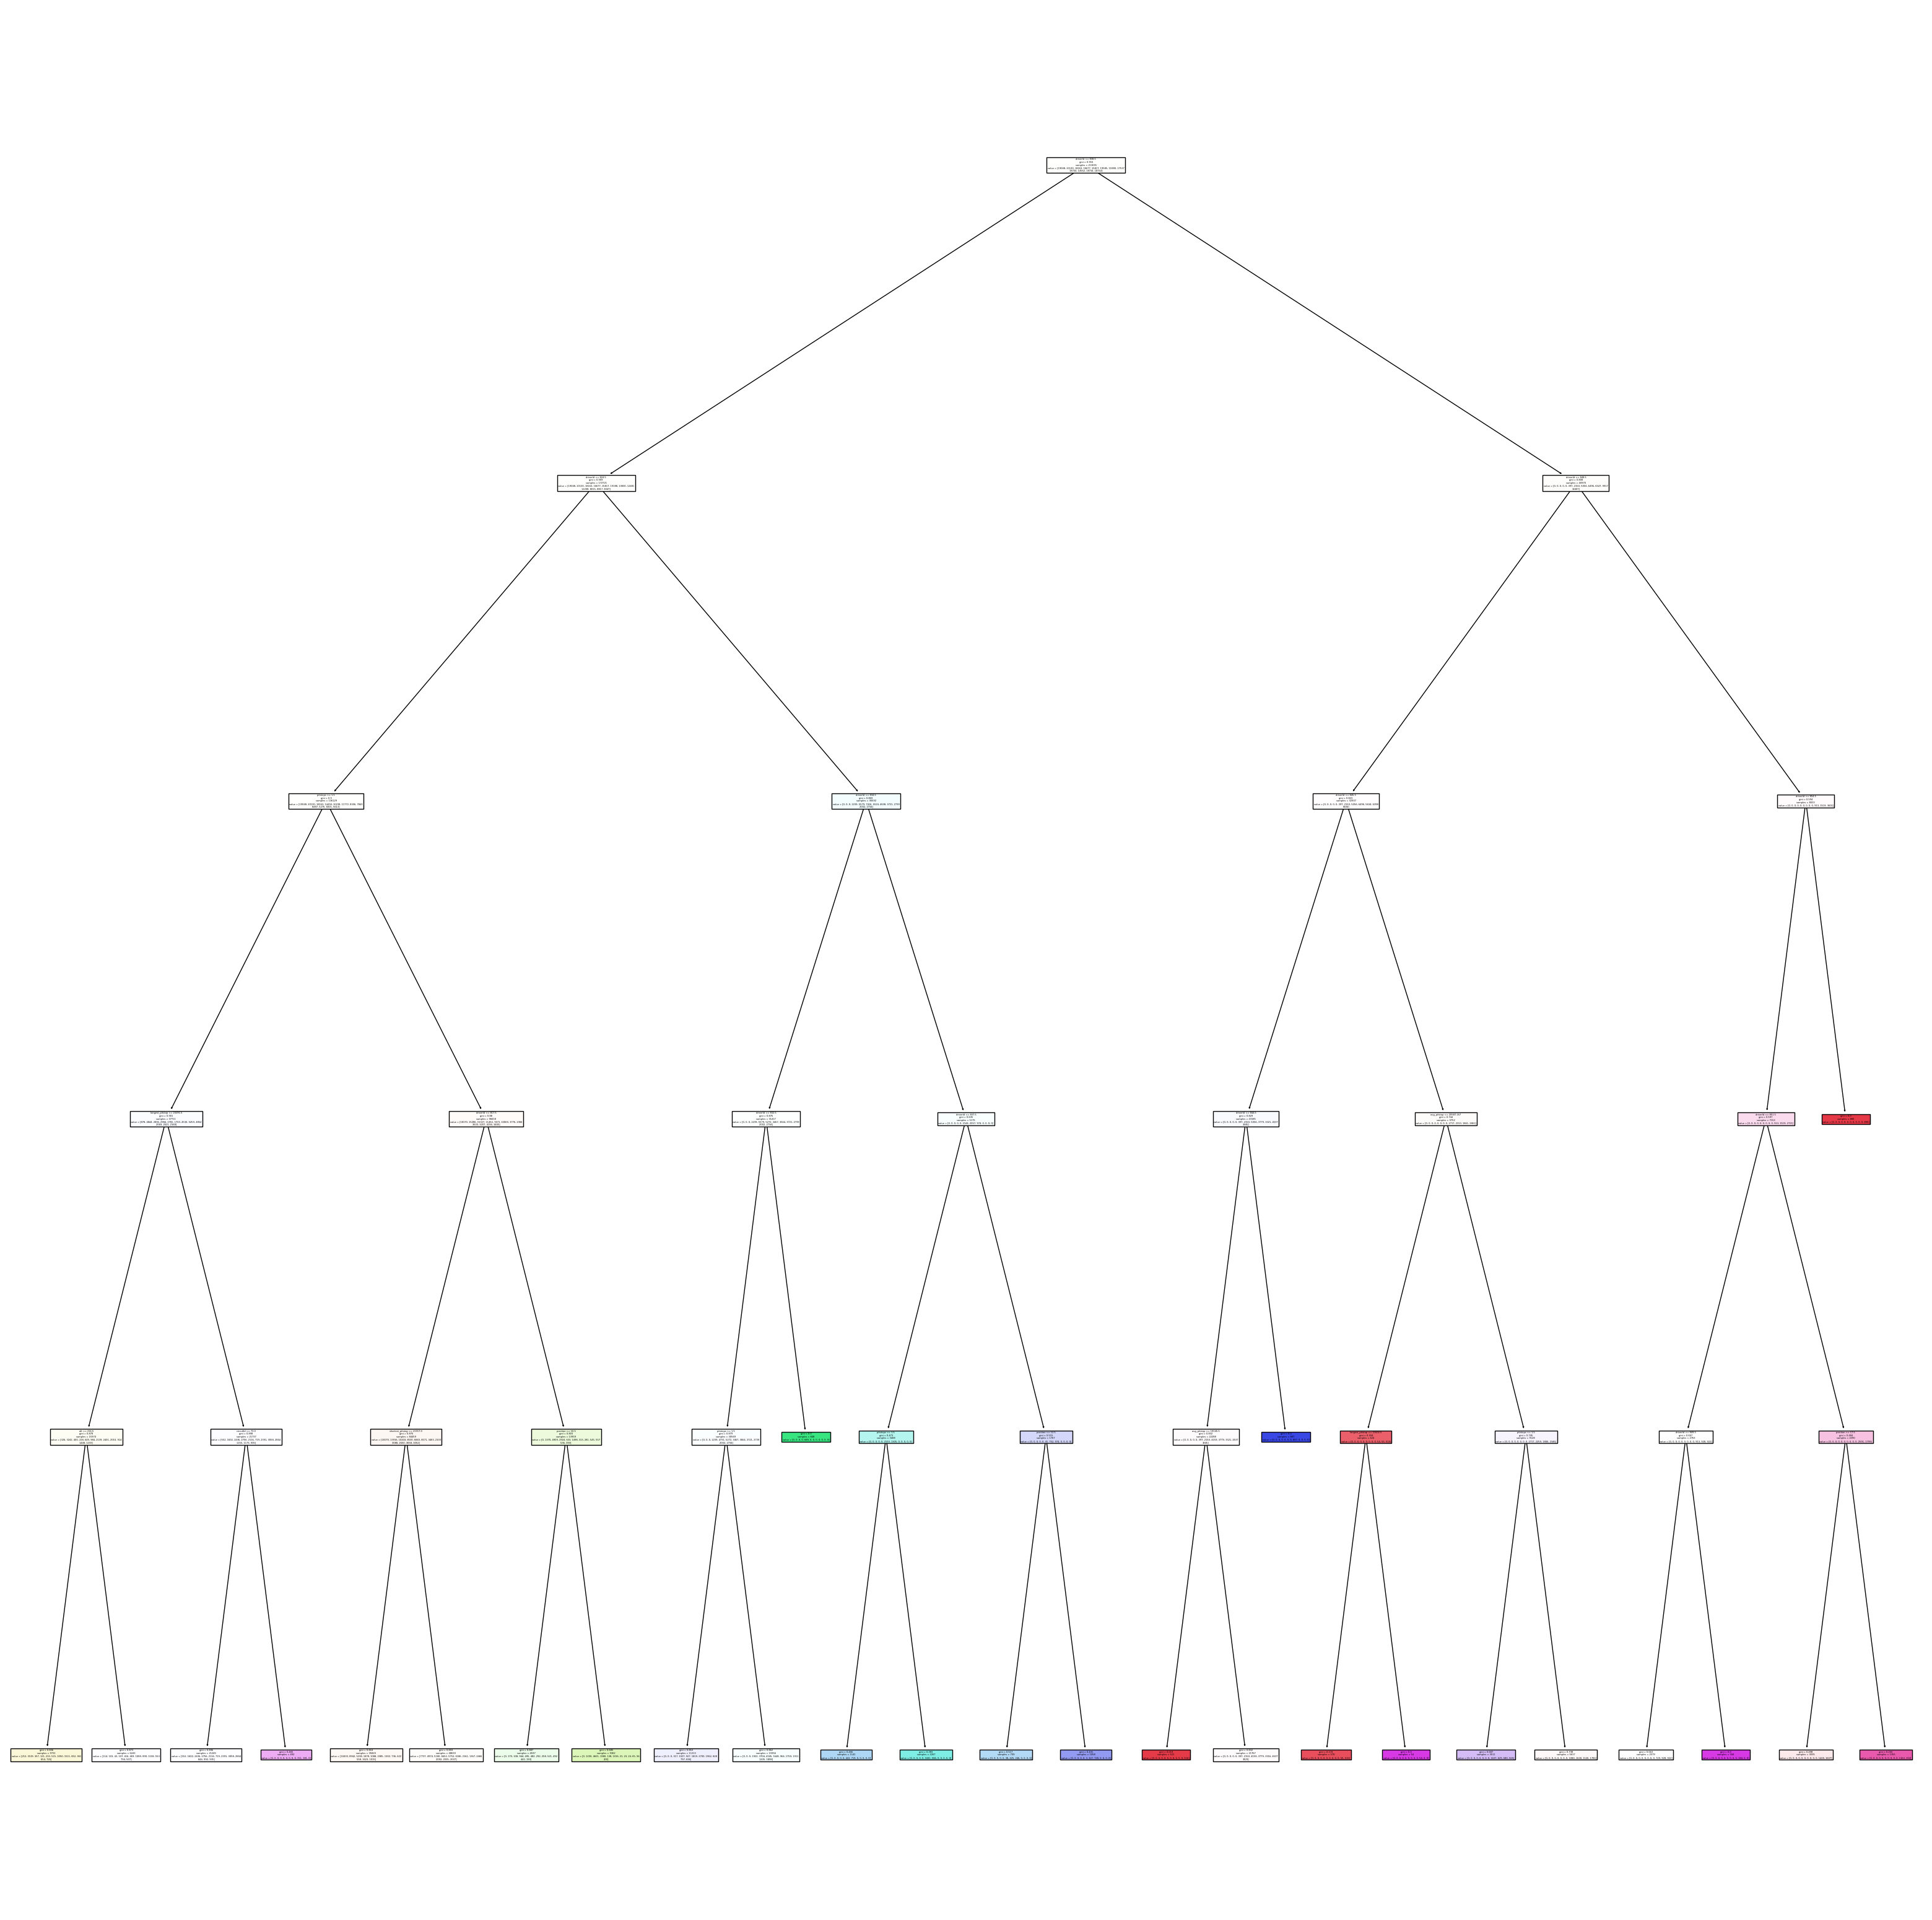

In [26]:
fig = plt.figure(figsize=(40,40))
_ = tree.plot_tree(clf,
               feature_names=fn,
               filled=True)

In [27]:
lr = LogisticRegression(solver='sag')
dt = DecisionTreeClassifier()
rn = RandomForestClassifier()
knn = KNeighborsClassifier()
gb = GaussianNB()
sgd = SGDClassifier()

In [28]:
li = [lr,sgd,knn,gb,rn,dt]
d = {}
for i in li:
    i.fit(xtrain,ytrain)
    ypred = i.predict(xtest)
    print(i,":",accuracy_score(ypred,ytest)*100)
    d.update({str(i):i.score(xtest,ytest)*100})

LogisticRegression(solver='sag') : 14.795125694925407
SGDClassifier() : 9.640042678247198
KNeighborsClassifier() : 79.1737641090916
GaussianNB() : 12.578851805402167
RandomForestClassifier() : 99.8839451172716
DecisionTreeClassifier() : 99.07904834996162
